In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import Compose, Resize, Lambda
from imagenet_c import corrupt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cpu device


In [2]:
to_numpy = Lambda(lambda x: np.uint8(x))
gaussian_noise_transform = Lambda(lambda x: corrupt(x, severity=5, corruption_name='gaussian_noise'))

test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=Compose([
        to_numpy,
        gaussian_noise_transform
    ])
)

(28, 28)

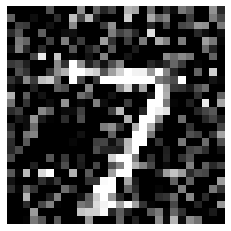

In [3]:
img = test_data[0][0]

plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')
type(img)
img.shape